## Final Project Machine Learning


In [23]:
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Audio
import tensorflow as tf
import os
import sys
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Conv2D, MaxPooling2D, SimpleRNN, LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping

### Introduction and Problem Statement

For my final project, I will do a music emotion recognition classification project. 

The dataset used is the Multi-Modal MIREX Emotion Dataset, where there are 903 audio clips that are 30 seconds, clustered into 5 different emotions.

### Data Understanding and EDA

Lets take a sample of the audio files that we're working with. What we'll do first is to find the path for the audio files so that we can extract them efficiently.

In [24]:
audio_files = 'C:/Users/Kevin Sianto/Documents/UChicago/Machine Learning/Final Project/dataset/Audio'
music_directory = os.listdir(audio_files)

In [25]:
file_paths = []
for file_name in music_directory:
    file_path = os.path.join(audio_files, file_name)
    file_paths.append(file_path)
    
    
def extract_numeric_part(file_path):
    return [int(s) for s in os.path.basename(file_path).split('.') if s.isdigit()][0]

file_paths = sorted(file_paths, key=extract_numeric_part)

We will use the librosa library to load our data. The output of the librosa.load function is the samples in the form of a float array which captures the amplitudes of the audio at fixed lengths of time, and the sample rate of the audio, which is the number of samples per second. For example, if the sample rate of our audio file is 1000, a 30 second clip will have 30,000 samples.

In [26]:
samples, sample_rate = librosa.load(file_paths[1])

In [27]:
print(samples)
print(samples.shape)
print(sample_rate)

[-3.0357661e-17  8.3266727e-17 -7.2858386e-17 ... -6.5377592e-03
 -3.2878220e-03 -6.4485753e-03]
(652288,)
22050


From the above, we can see that the audio file has a sample rate of 22050 and with the sample shape as 652288, the audio is close to 30 seconds.

Displaying the audio waves:

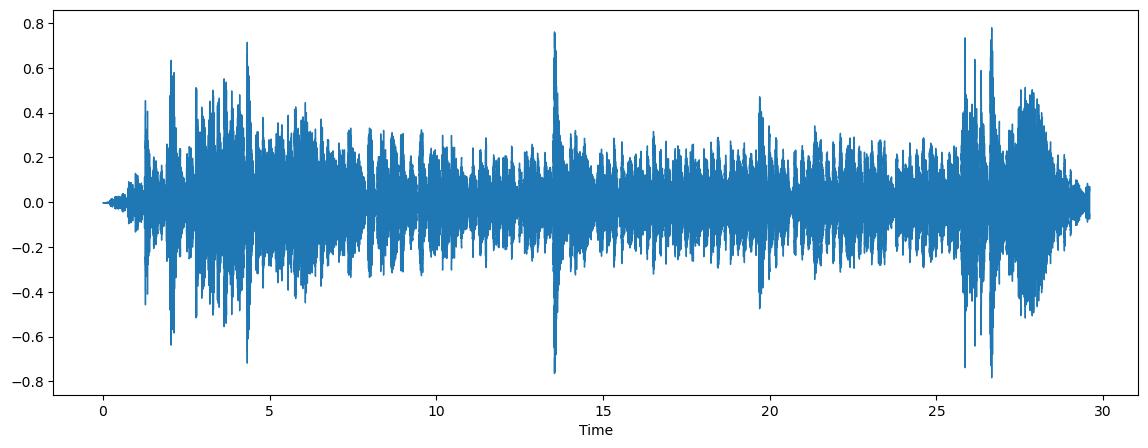

In [28]:
plt.figure(figsize = (14,5))
librosa.display.waveshow(samples, sr = sample_rate)

We can also play the audio that we've used using IPython functions. This function will be used more to see the results of our data augmentation.

In [29]:
Audio(samples, rate = sample_rate)

In the current state of audio deep learning, we don't use the raw audio files to extract the features needed for our model since that requires domain-specific expertise to tune the performance. The common approach now is to turn the audio files into images and then use CNN techniques to process the images. This is done by using spectograms.

Before we get to spectograms, let take some time to get some definitions down:

- Amplitude: the amplitude of a sound wave is tall or how short the wave is at a certain period of time, where its measured in decibels (db). It indicates how loud or soft the sound wave is. 
- Frequency: audio frequency represents the rate which a vibration/pressure wave occurs per second, where its measured by Hertz (Hz). It represents the pitch of a sound, for example a low pitch would be from 20Hz to 300Hz, and a high pitch will be from 5,000Hz to 20,000Hz. 

To explain what a spectogram does, let's first understand what a spectrum is. A spectrum is a set of frequencies that are combined to produce a signal. It plots the frequencies that are present in the signal along with the strength of the strength/amplitude of each frequency. 

Looking at the audio graph above, it shows the amplitudes of the audio file over time. It shows how loud or soft the audio is over a period of time, but it doesn't capture the frequencies of the audio file, even though its embedded in the audio file. A spectrum shows the same information in a different way, where it plots the amplitude over the frequency in a moment of time.

A spectogram shows the spectrum over time, making it like a photograph of the signal, where it plots the time on the x axis and the frequencies on the y axis, and then it uses color to indicate the amplitude. We can create spectograms by using Forier Transformations on the audio file.

Lets show an example of a spectrogram from the code below. The librosa library can create a spectrogram from the audio files that we have:

C:\Users\Kevin Sianto\AppData\Local\Temp\ipykernel_24104\2304845838.py:2: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  librosa.display.specshow(sgram)


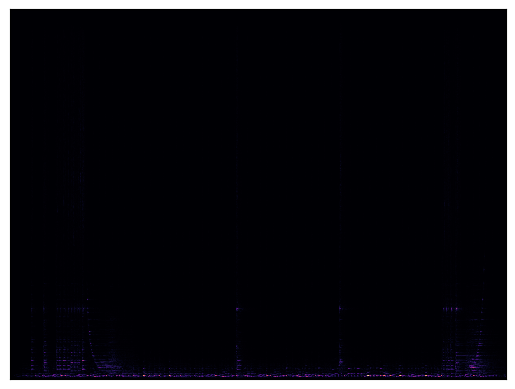

In [30]:
sgram = librosa.stft(samples)
librosa.display.specshow(sgram)

We created the spectrogram above, but it doesn't seem to show us that much information. As we mentioned previously, the spectrogram plots frequency vs time, and uses the amplitude as colors. The graph above barely shows us information on this. How do we solve this issue?

This lies in the way that humans perceive sound in two ways. The first is the way that humans perceive pitch. Humans perceive pitch in a logarithmic scale rather than a linear scale, where we are more sensitive to the differences between lower frequencies than higher frequencies. To account for this, the Mel scale was developed to take into account the logarithmic scale, where it scales the pitches where each unit is judged by the listener to be equal in pitch distance to the next one

The second is the way that humans perceive amplitudes, where similarly to frequency, we hear loudness logarithmically rather than linearly. To capture this, we use the decibel scale instead of the amplitude.

To account for both these issues, the Mel spectogram was developed, where it uses the Mel scale instead of frequencies in the y axis, and uses the decibel scale instead of amplitude to indicate the colors.

Let's do this using the code below:

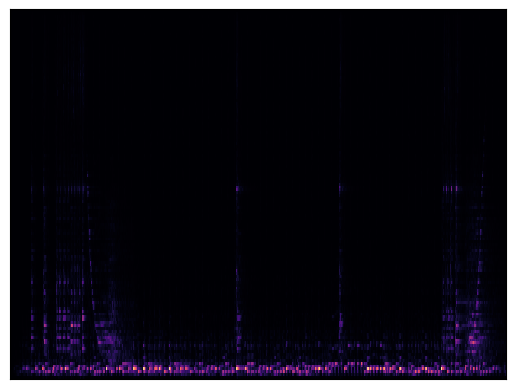

In [31]:
sgram_mag, _  = librosa.magphase(sgram)
mel_scale_sgram = librosa.feature.melspectrogram(S = sgram_mag, sr = sample_rate)
librosa.display.specshow(mel_scale_sgram)

The code above changes the y axis from the frequencies to the Mel scale. We'll do one more step to change the colors from the amplitudes to the decibel scale.

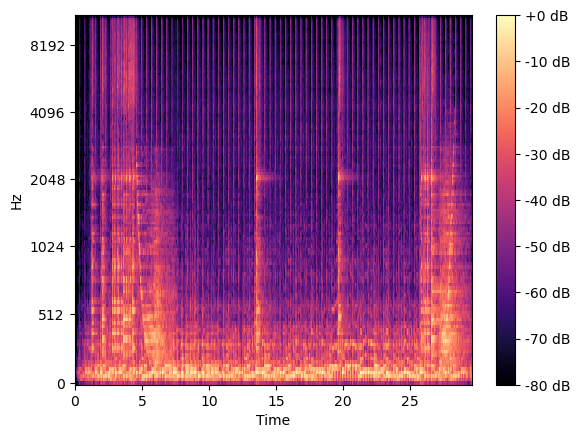

In [32]:
mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.max)
librosa.display.specshow(mel_sgram, sr=sample_rate, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')

This is the final product of the Mel Spectrogram. Lets look at the shape of the Mel Spectrogram:

In [33]:
print(mel_sgram.shape)

(128, 1275)


Using the Mel Spectrogram when we feed it to the Deep Learning Model later where we will have to flatten the data, it will result in around 150,000 rows, which is quite hefty for our model to run. We will instead use another form of a Mel Spectrogram called Mel Frequency Cepstral Coefficient (MFCC), where it shows a compressed representation of frequency bands that removes redundant information. We will show it in the code below:

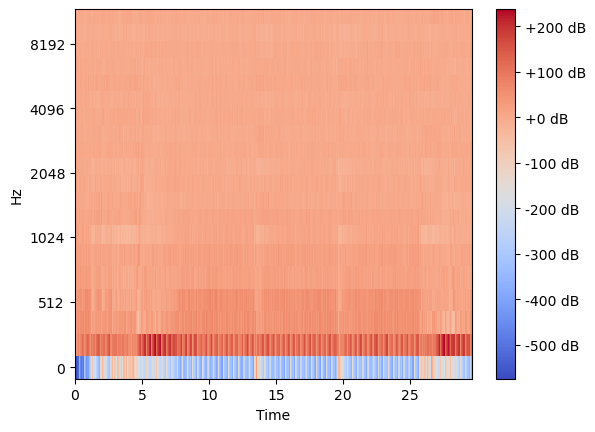

In [34]:
mfcc_sample = librosa.feature.mfcc(y = samples, sr = sample_rate)
librosa.display.specshow(mfcc_sample, sr=sample_rate, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')

Let's check the shape of the MFCC:

In [35]:
mfcc_sample.shape

(20, 1275)

Awesome, the data is around 6 times smaller than the Mel Spectrogram, so we'll use this as the data for training our data.

Now lets find check the clusters that we have and set them with the file path that we have for each audio file so we can efficiently create our dataset.

In [36]:
txt_file_path = 'C:/Users/Kevin Sianto/Documents/UChicago/Machine Learning/Final Project/dataset/clusters.txt'

cluster_numbers = []

with open(txt_file_path, 'r') as file:
    for line in file:
        # Assuming each line contains "Cluster" followed by a space and the cluster number
        if line.startswith('Cluster'):
            _, cluster_number = line.strip().split()
            cluster_numbers.append(int(cluster_number))

In [37]:
cluster_numbers[5]

1

In [38]:
file_paths_df = pd.DataFrame(file_paths, columns=['Path'])
cluster_numbers_df = pd.DataFrame(cluster_numbers, columns=['Cluster'])
data_path_df = pd.concat([cluster_numbers_df, file_paths_df], axis=1)

In [39]:
data_path_df

Cluster                                               Path
0          1  C:/Users/Kevin Sianto/Documents/UChicago/Machi...
1          1  C:/Users/Kevin Sianto/Documents/UChicago/Machi...
2          1  C:/Users/Kevin Sianto/Documents/UChicago/Machi...
3          1  C:/Users/Kevin Sianto/Documents/UChicago/Machi...
4          1  C:/Users/Kevin Sianto/Documents/UChicago/Machi...
..       ...                                                ...
898        5  C:/Users/Kevin Sianto/Documents/UChicago/Machi...
899        5  C:/Users/Kevin Sianto/Documents/UChicago/Machi...
900        5  C:/Users/Kevin Sianto/Documents/UChicago/Machi...
901        5  C:/Users/Kevin Sianto/Documents/UChicago/Machi...
902        5  C:/Users/Kevin Sianto/Documents/UChicago/Machi...

[903 rows x 2 columns]

Lets check the distribution of our clusters:

In [40]:
data_path_df['Cluster'].value_counts()

3    215
4    191
1    170
2    164
5    163
Name: Cluster, dtype: int64

<Axes: xlabel='Cluster', ylabel='count'>

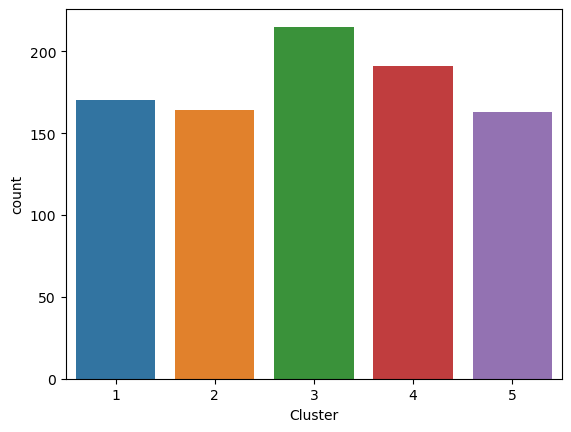

In [41]:
sns.countplot(data_path_df, x = 'Cluster')

The data is relatively balanced.

### Data Augmentation and Feature Extraction

We have 903 audio files to work with. That's not alot of data that we can use. To fix this issue, lets do some data augmentation of the audio data so that we have more samples to work with.

There are 3 things that we will do to the data:

1. Add noise
2. Shift Pitch
3. Shift the audio file

In [42]:
# Noise Augmentation

def noise(audio):
    noise_change = 0.05 * np.random.uniform()*np.amax(audio)
    audio = audio + noise_change * np.random.normal(size = audio.shape[0])
    return audio

# Pitch Shift

def pitch_shift(audio, sampling_rate, pitch_factor):
    return librosa.effects.pitch_shift(audio, sr = sampling_rate, n_steps = pitch_factor)

# Shift
def shift(data):
    shift_range = int(np.random.uniform(low=-10, high = 10)*1000)
    return np.roll(data, shift_range)

For each of the augmentation techniques that we'll do, an example will be shown to see the difference in the augmented data.

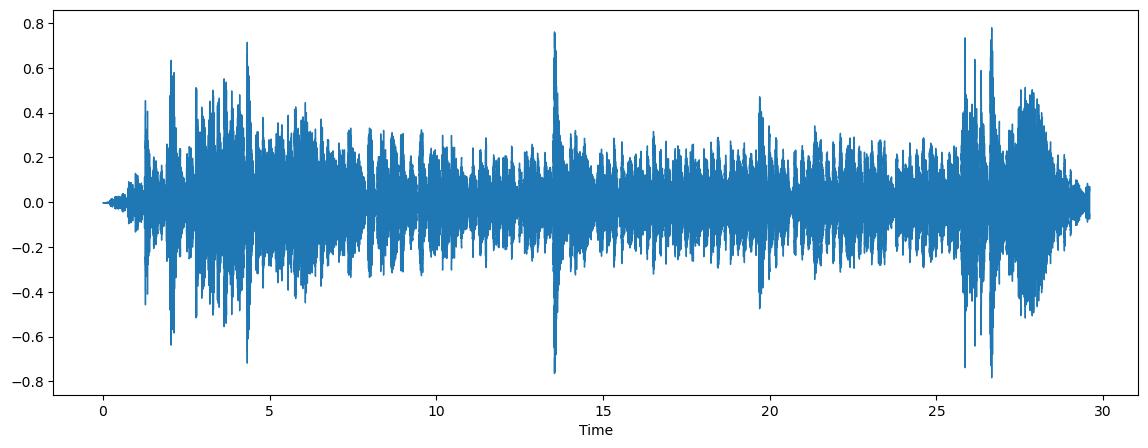

In [43]:
plt.figure(figsize = (14,5))
librosa.display.waveshow(samples, sr = sample_rate)
Audio(samples, rate = sample_rate)

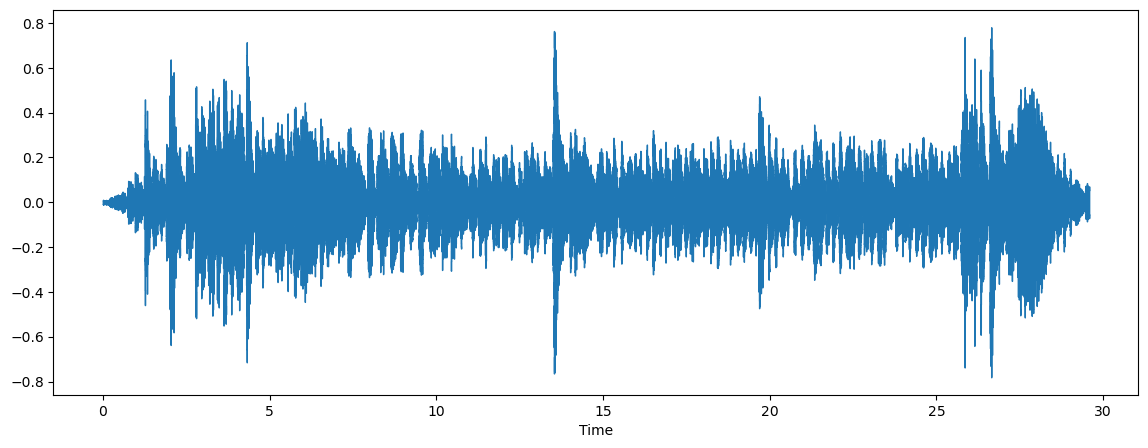

In [44]:
# Noisy Audio
noise_samples = noise(samples)
plt.figure(figsize = (14,5))
librosa.display.waveshow(noise_samples, sr = sample_rate)
Audio(noise_samples, rate = sample_rate)

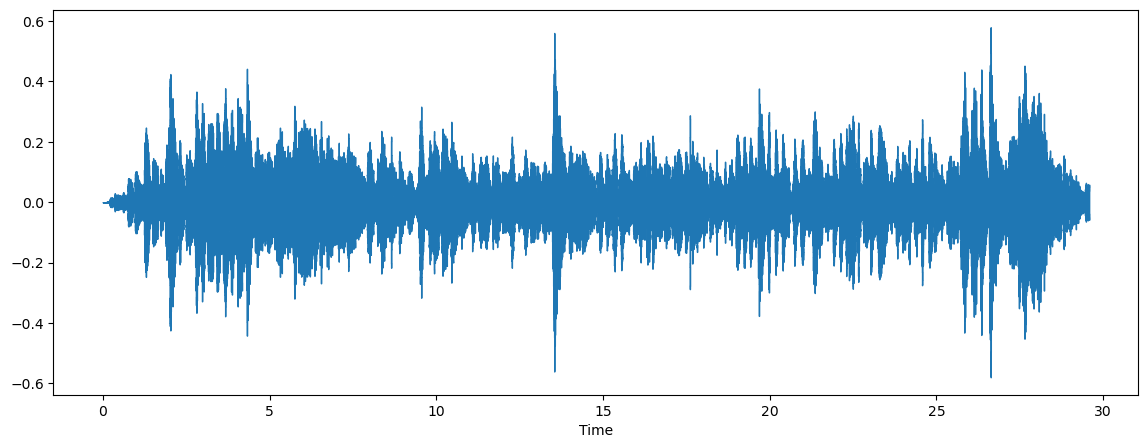

In [45]:
# Pitched Audio
pitched_samples = pitch_shift(samples, sampling_rate = sample_rate, pitch_factor= 1)
plt.figure(figsize = (14,5))
librosa.display.waveshow(pitched_samples, sr = sample_rate)
Audio(pitched_samples, rate = sample_rate)

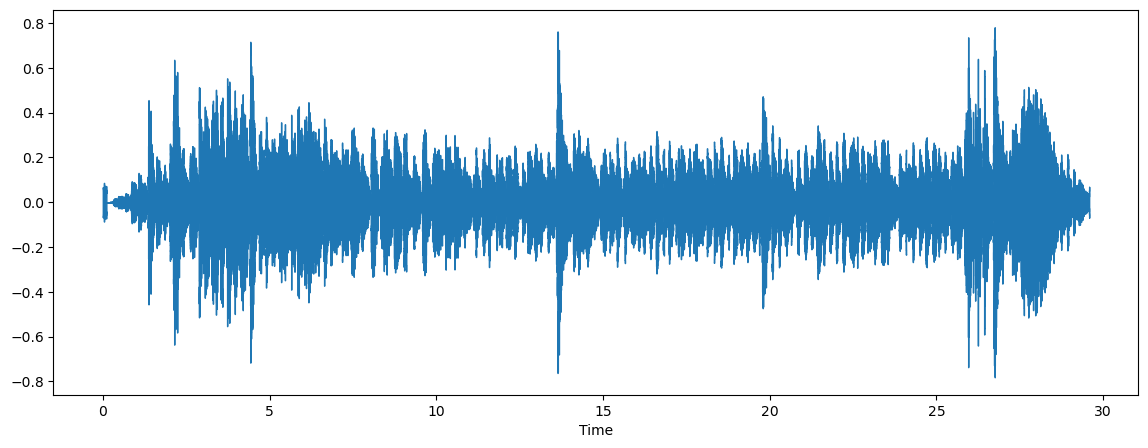

In [46]:
# Shifted Audio
shifted_samples = shift(samples)
plt.figure(figsize = (14,5))
librosa.display.waveshow(shifted_samples, sr = sample_rate)
Audio(shifted_samples, rate = sample_rate)

In addition to the MFCC, we will take a few other features that we will use to create our data set.

The zero crossing rate is a measure that captures how frequently the signal changes sign (crosses the horizontal axis) in a given time frame. This is useful for capturing percussive elements in an audio file, where it may have higher ZCR, capturing pitch and is a technique that is used in audio deep learning.

The root mean square in audio data is used to quantify the error of a distortion in a signal and to assess the energy or the loudness of the system.

We'll create the definitions from the librosa library below:

In [47]:
# Zero crossing rate
def zcr(data):
    zcr=librosa.feature.zero_crossing_rate(data)
    return np.squeeze(zcr)

# Root mean square
def rmse(data):
    rmse=librosa.feature.rms(y=data)
    return np.squeeze(rmse)

def mfcc_data(data,sample_rate,flatten:bool=True):
    mfcc=librosa.feature.mfcc(y=data,sr=sample_rate)
    return np.squeeze(mfcc.T)if not flatten else np.ravel(mfcc.T)

We'll next create a definition to extract the audio features and stack them in a numpy array

In [48]:
def extract_audio_features(data, sample_rate = 22050):
    result = np.array([])
    result = np.hstack((result,
                        zcr(data),
                        rmse(data),
                        mfcc_data(data, sample_rate = sample_rate)
                        ))
    
    return result

Then we'll create a definition to get the features of the audio files with the original dataset, as well as the augmented audio.

In [49]:
def get_features(path,duration=28, offset=0.6):
    data,sr=librosa.load(path,duration=duration,offset=offset,mono=True)
    aud=extract_audio_features(data)
    audio=np.array(aud)
    
    noised_audio=noise(data)
    aud2=extract_audio_features(noised_audio)
    audio=np.vstack((audio,aud2))
    
    pitched_audio=pitch_shift(data,sr, pitch_factor=1)
    aud3=extract_audio_features(pitched_audio)
    audio=np.vstack((audio,aud3))
    
    shifted_audio=shift(data)
    aud4=extract_audio_features(shifted_audio)
    audio=np.vstack((audio,aud4))
    
    return audio

We'll run it with the data that we have:

In [50]:
X,Y=[],[]
for path,emotion,index in zip(data_path_df['Path'],data_path_df['Cluster'],range(data_path_df['Path'].shape[0])):
    features=get_features(path)
    if index%500==0:
        print(f'{index} audio has been processed')
    for i in features:
        X.append(i)
        Y.append(emotion)
print('Done')

0 audio has been processed
500 audio has been processed
Done


Checking the shape of our dataset:

In [51]:
len(X), len(Y), data_path_df['Path'].shape

(3612, 3612, (903,))

Create the final dataframe:

In [52]:
final_df = pd.DataFrame(X)
final_df['Cluster'] = Y
final_df.head()

0         1         2         3         4         5         6  \
0  0.068848  0.152344  0.193359  0.201172  0.201172  0.148438  0.138672   
1  0.177246  0.269531  0.331543  0.301270  0.293457  0.264648  0.268555   
2  0.076172  0.137207  0.186035  0.193848  0.193848  0.168457  0.145020   
3  0.045410  0.080566  0.121094  0.137207  0.160645  0.167480  0.161621   
4  0.003906  0.005859  0.007812  0.010254  0.029297  0.031738  0.033203   

          7         8         9  ...      26523     26524      26525  \
0  0.117188  0.105957  0.098145  ...   4.576486 -6.084823   0.972753   
1  0.256836  0.263184  0.271973  ...  -1.813685  2.244772   2.824204   
2  0.127930  0.105469  0.099609  ...   5.036520 -0.021739  13.304585   
3  0.150879  0.166504  0.167480  ...  15.273074 -2.625613  -6.162822   
4  0.031250  0.012695  0.010742  ...   5.458147  1.508280   2.371639   

      26526      26527     26528      26529      26530      26531  Cluster  
0  0.282737  -7.802341 -2.931611 -14.446407 -15.551275  -2.425959        1  
1 -2.845475  -4.082532 -3.161650  -3.140084  -4.012137  -0.569228        1  
2  0.629039  -1.857510 -9.758419 -22.158123  -5.541052  15.597667        1  
3 -5.586649 -14.219975 -0.019136   9.769669  -4.485087  -8.835511        1  
4  4.184718  -0.171588 -7.751961   5.440473  -3.591165   4.499329        1  

[5 rows x 26533 columns]

In [53]:
final_df['Cluster'].value_counts()

3    860
4    764
1    680
2    656
5    652
Name: Cluster, dtype: int64

Now we check if there are any null values from the feature extraction, and replace the null values with zeros so that its ready for modeling:

In [54]:
print(final_df.isna().any())

0          False
1          False
2          False
3          False
4          False
           ...  
26528       True
26529       True
26530       True
26531       True
Cluster    False
Length: 26533, dtype: bool


In [55]:
final_df=final_df.fillna(0)
print(final_df.isna().any())
final_df.shape

0          False
1          False
2          False
3          False
4          False
           ...  
26528      False
26529      False
26530      False
26531      False
Cluster    False
Length: 26533, dtype: bool


(3612, 26533)

Split the data to Input and Output:

In [56]:
X = final_df.drop(columns = 'Cluster', axis = 1).values
y = final_df['Cluster'].values

Since this is a multilabel classification, we'll create a one hot encoding for the output:

In [57]:
encoder = OneHotEncoder()
y = encoder.fit_transform(np.array(y).reshape(-1,1)).toarray()

In [58]:
y

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

Split data 80/20:

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 7)

Scale the data using Standard Scaler:

In [60]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Change the shape of our training data so that its ready to be fed into a CNN:

In [61]:
X_train_cnn =np.expand_dims(X_train_scaled, axis=2)
X_test_cnn= np.expand_dims(X_test_scaled, axis=2)

In [62]:
X_train_cnn.shape

(2889, 26532, 1)

### Modeling

For this model, we will be using 1D Convolutional Neural Networks instead of 2D CNNs. The reason we use 1D CNNs is because its more useful for sequential data such as audio data, where CNNs are used for image data with height and width.

For our first model, we will use CNN layers with batch normalization and Max Pooling nodes, which is then flattened and the final output is a softmax function.

In [63]:
model = Sequential([
    Conv1D(16, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(X_train.shape[1], 1)),
    BatchNormalization(),
    MaxPooling1D(pool_size=5, strides=2, padding='same'),
    
    Conv1D(32,kernel_size=3,strides=1,padding='same',activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=3,strides=2,padding='same'),
    Dropout(0.3),

    Conv1D(64,kernel_size=3,strides=1,padding='same',activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=3,strides=2,padding='same'),
    Dropout(0.2),
    
    Flatten(),
    Dense(64,activation='relu'),
    BatchNormalization(),
    Dense(5,activation='softmax')
])
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

c:\Users\Kevin Sianto\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 26532, 16)      │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 26532, 16)      │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 13266, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 13266, 32)      │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 13266, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 6633, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6633, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 6633, 64)       │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 6633, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 3317, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3317, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 212288)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    13,586,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,595,397 (51.86 MB)

 Trainable params: 13,595,045 (51.86 MB)

 Non-trainable params: 352 (1.38 KB)

In [64]:
early_stop = EarlyStopping(monitor = 'val_accuracy', patience = 3, verbose = 1, restore_best_weights=True)

In [65]:
history=model.fit(X_train_cnn, y_train,
                  epochs=30,
                  validation_data=(X_test_cnn, y_test),
                  batch_size=16,
                  callbacks=early_stop)

Epoch 1/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 21s 109ms/step - accuracy: 0.3500 - loss: 1.5635 - val_accuracy: 0.2185 - val_loss: 91.5004
Epoch 2/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 20s 112ms/step - accuracy: 0.8585 - loss: 0.5011 - val_accuracy: 0.4827 - val_loss: 1.2659
Epoch 3/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 21s 115ms/step - accuracy: 0.9771 - loss: 0.1342 - val_accuracy: 0.7137 - val_loss: 0.9746
Epoch 4/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 20s 110ms/step - accuracy: 0.9905 - loss: 0.0646 - val_accuracy: 0.8230 - val_loss: 0.5409
Epoch 5/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 20s 110ms/step - accuracy: 0.9945 - loss: 0.0439 - val_accuracy: 0.4799 - val_loss: 2.5518
Epoch 6/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 20s 109ms/step - accuracy: 0.9913 - loss: 0.0498 - val_accuracy: 0.7538 - val_loss: 0.7221
Epoch 7/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 20s 109ms/step - accuracy: 0.9928 - loss: 0.0394 - val_accuracy: 0.7524 - val_loss: 0.6782
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 4.

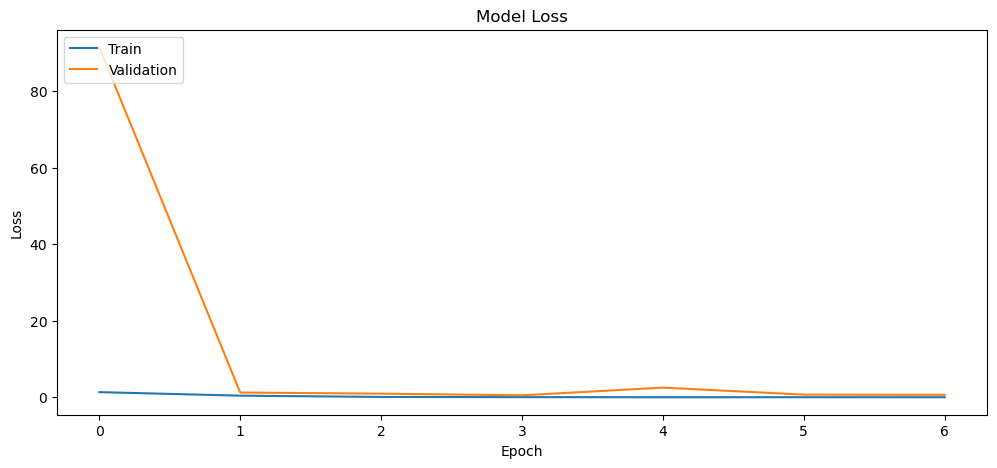

In [66]:
plt.figure(figsize=(12, 5))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [67]:
results = model.evaluate(X_test_cnn, y_test, batch_size=16)
print(f'Test loss, Test accuracy: {results}')

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7985 - loss: 0.5951
Test loss, Test accuracy: [0.5408532619476318, 0.8229598999023438]


In [68]:
model2 = Sequential([
    Conv1D(32, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(X_train.shape[1], 1)),
    BatchNormalization(),
    MaxPooling1D(pool_size=5, strides=2, padding='same'),
    Conv1D(64,kernel_size=3,strides=1,padding='same',activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=3,strides=2,padding='same'),
    Dropout(0.3),
    Flatten(),
    Dense(8,activation='relu'),
    BatchNormalization(),
    Dense(5,activation='softmax')
])
model2.compile(optimizer='AdamW',loss='categorical_crossentropy',metrics=['accuracy'])
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 26532, 32)      │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 26532, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 13266, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 13266, 64)      │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 13266, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 6633, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6633, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 424512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │     3,396,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 8)              │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │            45 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,402,965 (12.98 MB)

 Trainable params: 3,402,757 (12.98 MB)

 Non-trainable params: 208 (832.00 B)

In [69]:
early_stop = EarlyStopping(monitor = 'val_accuracy', patience = 3, verbose = 1, restore_best_weights=True)

In [70]:
history2=model2.fit(X_train_cnn, y_train,
                  epochs=30,
                  validation_data=(X_test_cnn, y_test),
                  batch_size=16,
                  callbacks=early_stop)

Epoch 1/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 26s 136ms/step - accuracy: 0.2990 - loss: 1.6245 - val_accuracy: 0.1867 - val_loss: 3.0635
Epoch 2/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 24s 132ms/step - accuracy: 0.5568 - loss: 1.2292 - val_accuracy: 0.4205 - val_loss: 1.5454
Epoch 3/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 27s 148ms/step - accuracy: 0.8855 - loss: 0.6677 - val_accuracy: 0.7967 - val_loss: 0.8135
Epoch 4/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 30s 165ms/step - accuracy: 0.9801 - loss: 0.2984 - val_accuracy: 0.8326 - val_loss: 0.5680
Epoch 5/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 29s 161ms/step - accuracy: 0.9863 - loss: 0.1778 - val_accuracy: 0.8299 - val_loss: 0.5181
Epoch 6/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 29s 162ms/step - accuracy: 0.9862 - loss: 0.1258 - val_accuracy: 0.8368 - val_loss: 0.5029
Epoch 7/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 31s 170ms/step - accuracy: 0.9891 - loss: 0.0996 - val_accuracy: 0.8202 - val_loss: 0.5654
Epoch 8/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 31s 172ms/step - accuracy: 0.9891 - loss: 0

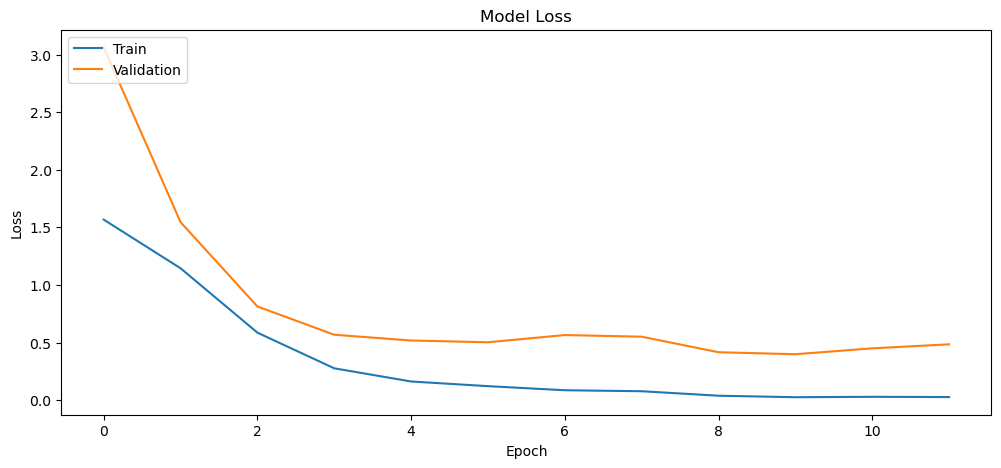

In [71]:
plt.figure(figsize=(12, 5))

plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [72]:
results = model2.evaluate(X_test_cnn, y_test, batch_size=16)
print(f'Test loss, Test accuracy: {results}')

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.8511 - loss: 0.4435
Test loss, Test accuracy: [0.41627129912376404, 0.8713693022727966]


In [73]:
model = Sequential([
    Conv1D(16, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(X_train.shape[1], 1)),
    BatchNormalization(),
    MaxPooling1D(pool_size=5, strides=2, padding='same'),
    
    Conv1D(32,kernel_size=3,strides=1,activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=3,strides=2),

    Conv1D(64,kernel_size=3,strides=1,activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=3,strides=2),

    Conv1D(128,kernel_size=3,strides=1,activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=3,strides=2),
    Dropout(0.2),
    
    Flatten(),
    Dense(64,activation='relu'),
    BatchNormalization(),
    Dense(5,activation='softmax')
])
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_5 (Conv1D)               │ (None, 26532, 16)      │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 26532, 16)      │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 13266, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 13264, 32)      │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 13264, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 6631, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 6629, 64)       │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 6629, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 3314, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 3312, 128)      │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 3312, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 1655, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1655, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 211840)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │    13,557,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,591,941 (51.85 MB)

 Trainable params: 13,591,333 (51.85 MB)

 Non-trainable params: 608 (2.38 KB)

In [74]:
early_stop = EarlyStopping(monitor = 'val_accuracy', patience = 7, verbose = 1, restore_best_weights=True)

In [75]:
history=model.fit(X_train_cnn, y_train,
                  epochs=30,
                  validation_data=(X_test_cnn, y_test),
                  batch_size=16,
                  callbacks=early_stop)

Epoch 1/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 32s 168ms/step - accuracy: 0.3351 - loss: 1.6143 - val_accuracy: 0.1936 - val_loss: 39.1738
Epoch 2/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 31s 172ms/step - accuracy: 0.8496 - loss: 0.4905 - val_accuracy: 0.7455 - val_loss: 0.8125
Epoch 3/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 31s 174ms/step - accuracy: 0.9790 - loss: 0.1351 - val_accuracy: 0.7911 - val_loss: 0.6148
Epoch 4/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 31s 171ms/step - accuracy: 0.9938 - loss: 0.0514 - val_accuracy: 0.8285 - val_loss: 0.4954
Epoch 5/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 31s 170ms/step - accuracy: 0.9987 - loss: 0.0257 - val_accuracy: 0.8479 - val_loss: 0.4522
Epoch 6/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 30s 168ms/step - accuracy: 0.9978 - loss: 0.0179 - val_accuracy: 0.8243 - val_loss: 0.4964
Epoch 7/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 30s 166ms/step - accuracy: 1.0000 - loss: 0.0082 - val_accuracy: 0.8285 - val_loss: 0.4964
Epoch 8/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 30s 165ms/step - accuracy: 0.9999 - loss: 

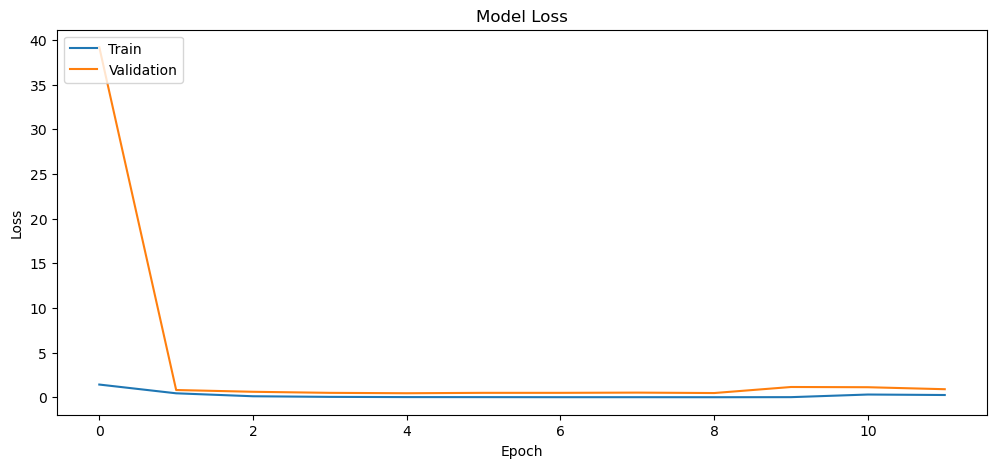

In [76]:
plt.figure(figsize=(12, 5))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [77]:
results = model.evaluate(X_test_cnn, y_test, batch_size=16)
print(f'Test loss, Test accuracy: {results}')

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8321 - loss: 0.5002
Test loss, Test accuracy: [0.4521925747394562, 0.8478561639785767]
